In [83]:
import numpy as np 
import pandas as pd 
import os 
import random 
from tqdm import tqdm 
import torch 
import torch.nn.functional as F 
import torch.nn as nn 
import json 
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from transformers import *
import pickle
import pandas_ta as ta # needed for processing chart data 
from random import randrange # needed for random agent
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor 
from sklearn.metrics import f1_score  
import ccxt 
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
df = pd.read_csv("4hours-v2/roberta.csv")
datetimes = df['datetime'].values 

train_idx, val_idx, test_idx, test_end_idx = -1,-1,-1, -1 

for i, d in enumerate(datetimes): 
    d = pd.to_datetime(d)
    if d.year == 2018 and d.month == 2 and d.day == 14 and d.hour == 16:
        train_idx = i
    elif d.year == 2021 and d.month == 6 and d.day == 16 and d.hour == 0:
        val_idx = i
    elif d.year == 2021 and d.month == 11 and d.day == 14 and d.hour == 20:
        test_idx = i 
    elif d.year == 2022 and d.month == 4 and d.day == 15 and d.hour == 20: 
        test_end_idx = i 
        
train_df = df.iloc[train_idx:val_idx] 
val_df = df.iloc[val_idx:test_idx] 
test_df = df.iloc[test_idx:test_end_idx+1] 

In [13]:
 train_df.shape, val_df.shape, test_df.shape

((7295, 37), (911, 37), (913, 37))

# Train High Model

In [50]:
'''
K: forecasting window 
'''
def preprocess_data(df, K=1, target_type = "high"): 
    future_discs = []
    disc_values = df[["months", "days", "hours"]] 
    
    for i in tqdm(range(disc_values.shape[0] - K)):
        future_disc = [] 
        for j in range(1,K+1):
            future_disc.append(disc_values.iloc[i+j,:])
        future_discs.append(future_disc)
    
    if target_type == "high":
        targets = df['high_delta'].values 
    elif target_type == "low":
        targets = df['low_delta'].values 
    
    disc_cols = ["months", "days", "hours"] 
    cont_cols = [] 
    cols = df.columns 
    for col in cols: 
        if col not in disc_cols and col != 'high_delta' and col != 'low_delta' and col != 'datetime': 
            cont_cols.append(col) 
    
    df_cont = df[cont_cols].values 
    df_disc = df[disc_cols].values 
        
    df_cont = torch.tensor(df_cont, dtype=torch.float32) 
    df_disc = torch.tensor(df_disc, dtype=torch.float32) 
    
    num_cont_features = len(cont_cols) 
    num_disc_features = len(disc_cols) 
    
    df_cont = torch.reshape(df_cont, (-1,1,num_cont_features,1))
    df_disc = torch.reshape(df_disc, (-1,1,num_disc_features)) 
    
    df_targets = torch.tensor(targets, dtype=torch.float32)
    df_targets = torch.reshape(df_targets, (-1,K,1)) 
    
    df_future_discs = torch.tensor(future_discs, dtype=torch.float32)
    df_future_discs = torch.reshape(df_future_discs, (-1, K, num_disc_features))
    
    return df_cont[:-1], df_targets[:-1], df_disc[:-1], df_future_discs 

In [51]:
train_cont, train_targets, train_disc, train_future_discs = preprocess_data(train_df)

100%|██████████| 7294/7294 [00:01<00:00, 4777.10it/s]


In [52]:
train_cont.shape, train_targets.shape, train_disc.shape, train_future_discs.shape

(torch.Size([7294, 1, 31, 1]),
 torch.Size([7294, 1, 1]),
 torch.Size([7294, 1, 3]),
 torch.Size([7294, 1, 3]))

In [53]:
val_cont, val_targets, val_disc, val_future_discs = preprocess_data(val_df)

100%|██████████| 910/910 [00:00<00:00, 5870.99it/s]


In [54]:
val_cont.shape, val_targets.shape, val_disc.shape, val_future_discs.shape

(torch.Size([910, 1, 31, 1]),
 torch.Size([910, 1, 1]),
 torch.Size([910, 1, 3]),
 torch.Size([910, 1, 3]))

In [55]:
test_cont, test_targets, test_disc, test_future_discs = preprocess_data(test_df)

100%|██████████| 912/912 [00:00<00:00, 5997.29it/s]


In [56]:
test_cont.shape, test_targets.shape, test_disc.shape, test_future_discs.shape

(torch.Size([912, 1, 31, 1]),
 torch.Size([912, 1, 1]),
 torch.Size([912, 1, 3]),
 torch.Size([912, 1, 3]))

In [57]:
BATCH_SIZE = 32

class CustomDataset(Dataset): 
    def __init__(self, past_cont, past_disc, target_seq, future_disc): 
        self.past_cont = past_cont
        self.past_disc = past_disc 
        self.target_seq = target_seq  
        self.future_disc = future_disc 
        
    def __len__(self): 
        return len(self.past_cont) 
    
    def __getitem__(self, i):  
        return {
            'past_cont': torch.tensor(self.past_cont[i], dtype=torch.float32), 
            'past_disc': torch.tensor(self.past_disc[i], dtype=torch.float32), 
            'target_seq': torch.tensor(self.target_seq[i], dtype=torch.float32),  
            'future_disc': torch.tensor(self.future_disc[i], dtype=torch.float32),  
        }

train_dataset = CustomDataset(train_cont, train_disc, train_targets, train_future_discs)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) 


val_dataset = CustomDataset(val_cont, val_disc, val_targets, val_future_discs) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False)



# Define TFT

Reference: https://github.com/LiamMaclean216/Temporal-Fusion-Transformer/blob/master/Network.py

In [58]:
def a_norm(Q, K): 
    m = torch.matmul(Q, K.transpose(2,1).float()) 
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float()) 
    return torch.softmax(m, -1) 

def attention(Q, K, V): 
    a = a_norm(Q, K) # (batch_size, dim_attn, seq_length) 
    return torch.matmul(a, V) # (batch_size, seq_length, seq_length) 

class AttentionBlock(torch.nn.Module): 
    def __init__(self, dim_val, dim_attn): 
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val) 
        self.key = Key(dim_val, dim_attn) 
        self.query = Query(dim_val, dim_attn) 
    
    def forward(self, x, kv = None):
        if kv is None:
            # Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        # Attention with x as Q, external vector kv as K and V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))



In [59]:
class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x) 


In [60]:
class GRN(torch.nn.Module): 
    def __init__(self, dim_input, dim_out=None, n_hidden=10, dropout_r=0.1):
        super(GRN, self).__init__() 
        if dim_out != None: 
            self.skip = nn.Linear(dim_input, dim_out) 
        else:
            self.skip = None
            dim_out = dim_input 
        self.fc1 = nn.Linear(dim_input, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, dim_out) 
        self.dropout = nn.Dropout(dropout_r) 
        self.gate = GLU(dim_out) 
        self.norm = nn.LayerNorm(dim_out) 
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        a = self.gate(a)
        if self.skip != None:
            return self.norm(self.skip(x) + a)
        return self.norm(x + a)



In [61]:
class VSN(torch.nn.Module): 
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r=0.1): 
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        # linear transformation of inputs into dmodel vectors 
        self.linearise = []
        for i in range(n_var_cont): 
            self.linearise.append(nn.Linear(1, dim_model, bias=False).cuda()) 
        
        self.fc = nn.Linear(1, dim_model, bias=False).cuda()     
        # entity embeddings for discrete inputs 
        self.entity_embed = [] 
        for i in n_var_disc: 
            self.entity_embed.append(nn.Linear(i, dim_model, bias=False).cuda())  
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.vs_grn = GRN(n_var_total * dim_model, dim_out=n_var_total, dropout_r = dropout_r)
    
    # input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc): 
        # linearise continuous inputs 
        linearised = [] 
        for idx, fc in enumerate(self.linearise): 
            linearised.append(fc(x_cont[:,:,idx])) 
        # entity embeddings for discrete inputs 
        embedded = []
        '''
        for idx, fc in enumerate(self.entity_embed): 
            embedded.append(fc(x_disc[:,:,idx]))
        '''
        for x, fc in zip(x_disc, self.entity_embed): 
            embedded.append(fc(x)) 

        if len(self.linearise) != 0 and len(self.entity_embed) != 0: 
            linearised = torch.stack(linearised, dim=-2) 
            embedded = torch.stack(embedded, dim=-2)    
            vectorised_vars = torch.cat((linearised, embedded), dim=-2) # (batch_size, seq_len, dim_model, n_vars_total)
        elif len(self.linearise) != 0 and len(self.entity_embed) == 0: 
            vectorised_vars = torch.stack(linearised, dim=-2) # (batch_size, seq_len, n_var_cont, dim_model)
        elif len(self.entity_embed) != 0 and len(self.linearise) == 0: 
            vectorised_vars = torch.stack(embedded, dim=-2)
        
        # flatten everything except accross batch for variable selection weights 
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim=2)) # (batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim=-1).unsqueeze(-1) # (batch_size, seq_len, n_variables, 1) 
        
        # input_grn applied to every input separately 
        input_weights = self.input_grn(vectorised_vars) # (batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2) 
        return x, vs_weights # returns (batch_size, seq_len, dim_model)


In [62]:
class LSTMLayer(torch.nn.Module): 
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers 
        self.dim_model = dim_model 
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True) 
        self.hidden = None
        self.dropout = nn.Dropout(dropout_r) 
    
    # takes input (batch_size, seq_len, dim_model)
    def forward(self, x): 
        if self.hidden == None: 
            raise Exception("Call reset() to initialise LSTM Layer") 
            
        x, self.hidden = self.lstm(x, self.hidden) 
        x = self.dropout(x) 
        return x, self.hidden # returns (batch_size, seq_len, dim_model), hidden 
    
    def reset(self, batch_size, gpu = True): 
        if not gpu: 
            dtype = torch.FloatTensor 
        else: 
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                       torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)) 


In [63]:
class TFN(torch.nn.Module): 
    def __init__(self, 
                 n_var_past_cont, 
                 n_var_future_cont,
                 n_var_past_disc, 
                 n_var_future_disc,
                 dim_model,
                 n_quantiles = 1, 
                 dropout_r = 0.1,
                 n_lstm_layers = 1,
                 n_attention_layers = 1,
                 n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r) 
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        
        self.gate1 = GLU(dim_model) 
        self.norm1 = nn.LayerNorm(dim_model) 
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = [] 
        for i in range(n_attention_layers): 
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()]) 
        
        self.norm2 = nn.LayerNorm(dim_model) 
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.norm3 = nn.LayerNorm(dim_model) 
        self.dropout = nn.Dropout(dropout_r) 
        self.fc_out = nn.Linear(dim_model, n_quantiles) 
        
    # takes input (batch_size, past_seq_len, n_variables_past) 
    # and (batch_size, future_seq_len, n_variables_future) 
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        # Encoder 
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc) 
        e, e_hidden = self.enc(x_past) 
        self.dec_hidden = e_hidden 
        e = self.dropout(e) 
        x_past = self.norm1(self.gate1(e) + x_past) 

        # Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc) 
        d, _ = self.dec(x_future) 
        d = self.dropout(d) 
        x_future = self.norm1(self.gate1(d) + x_future) 

        # static enrichment
        x = torch.cat((x_past, x_future), dim=1) # (batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x) 

        # attention layer 
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a) 
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future) 
        a = self.positionwise_grn(x_future) 
        x_future = self.norm3(a + x_future + attention_res) 
        net_out = self.fc_out(x_future)  
        return net_out, vs_weights 

    def reset(self, batch_size, gpu = True): 
        self.enc.reset(batch_size, gpu) 
        self.dec.reset(batch_size, gpu) 


In [87]:
features = train_cont.shape[2]

model = TFN(n_var_past_cont = features,
            n_var_future_cont = 0, 
            n_var_past_disc = [13, 32, 25], # months, days, hours
            n_var_future_disc = [13, 32, 25],
            dim_model = 160) 

model.cuda()

TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=5440, out_features=34, bias=True)
      (fc1): Linear(in_features=5440, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=34, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=34, out_features=34, bias=True)
        (fc2): Linear(in_features=34, out_features=34, bias=True)
      )
      (norm): LayerNorm((34,), eps=1e-05, elementwise_aff

In [88]:
device = torch.device('cuda')

epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5) 

train_losses, val_losses = [], []  

criterion = nn.MSELoss()  

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [89]:
def evaluate(data_dataloader): 
    eval_loss = 0 
    for step, batch in enumerate(tqdm(data_dataloader, desc="Validation", smoothing=0.05, position=0, leave=True)): 
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device)
        
        past_disc = one_hot(past_disc, [13, 32, 25]) 
        future_disc = one_hot(future_disc, [13, 32, 25]) 
        
        model.reset(batch_size=past_cont.shape[0], gpu=True) 
        with torch.no_grad():
            net_out, vs_weights = model(past_cont, past_disc, None, future_disc)  
        loss = criterion(net_out, target_seq)
        eval_loss += loss.item() 
    avg_val_loss = eval_loss / len(data_dataloader)    
    return avg_val_loss, net_out, vs_weights

# for processing discrete features 
def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
    
    # print("Converting to one hot vector")
    for i in range(0, x.shape[-1]): # get rid of tqdm for training 
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out


In [ ]:
for i in tqdm(range(epochs), desc="Epochs", position=0, leave=True): 
    print("")
    print("======= Epoch {:} / {:} =======".format(i+1, epochs))
    print("Training...") 
    total_loss = 0 
    model.train() 
    
    for batch in tqdm(train_dataloader, desc="Training", smoothing=0.05, position=0, leave=True):                
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device) 
        model.reset(batch_size=past_cont.shape[0], gpu=True)
        past_disc = one_hot(past_disc, [13, 32, 25]) 
        future_disc = one_hot(future_disc, [13, 32, 25])  
                
        optimizer.zero_grad() 
        net_out, vs_weights = model(past_cont, past_disc, None, future_disc) 
        
        loss = criterion(net_out, target_seq) 
        total_loss += loss.item() 
        loss.backward() # back propagation 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping 
        optimizer.step() 
        scheduler.step() 
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)  
    
    print("Validating...")
    model.eval() 
    val_loss, _, _ = evaluate(val_dataloader) 
    val_losses.append(val_loss) 
    if np.min(val_losses) == val_losses[-1]: 
        print("Saving Best Checkpoint...") 
        torch.save(model.state_dict(), "TFT_EMNLP_example.pt") 

print("") 
print("Training Complete!")


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


======= Epoch 1 / 50 =======
Training...


Training:   0%|          | 0/228 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct fro

Validating...


Epochs:   2%|▏         | 1/50 [00:19<15:41, 19.22s/it]

Saving Best Checkpoint...

======= Epoch 2 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.11it/s]


Validating...


Epochs:   4%|▍         | 2/50 [00:31<12:08, 15.17s/it]

Saving Best Checkpoint...

======= Epoch 3 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.67it/s]


Validating...


Epochs:   6%|▌         | 3/50 [00:43<10:34, 13.50s/it]

Saving Best Checkpoint...

======= Epoch 4 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.03it/s]


Validating...


Epochs:   8%|▊         | 4/50 [00:54<09:50, 12.83s/it]

Saving Best Checkpoint...

======= Epoch 5 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.16it/s]


Validating...


Epochs:  10%|█         | 5/50 [01:06<09:19, 12.44s/it]

Saving Best Checkpoint...

======= Epoch 6 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:12<00:00, 18.94it/s]


Validating...


Epochs:  12%|█▏        | 6/50 [01:19<09:07, 12.45s/it]

Saving Best Checkpoint...

======= Epoch 7 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.45it/s]


Validating...


Epochs:  14%|█▍        | 7/50 [01:31<08:53, 12.40s/it]

Saving Best Checkpoint...

======= Epoch 8 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.92it/s]


Validating...


Epochs:  16%|█▌        | 8/50 [01:43<08:33, 12.23s/it]


======= Epoch 9 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.84it/s]


Validating...


Epochs:  18%|█▊        | 9/50 [01:55<08:17, 12.13s/it]


======= Epoch 10 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.51it/s]


Validating...


Epochs:  20%|██        | 10/50 [02:06<07:57, 11.94s/it]

Saving Best Checkpoint...

======= Epoch 11 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.56it/s]


Validating...


Epochs:  22%|██▏       | 11/50 [02:18<07:41, 11.82s/it]

Saving Best Checkpoint...

======= Epoch 12 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.81it/s]


Validating...


Epochs:  24%|██▍       | 12/50 [02:30<07:30, 11.86s/it]

Saving Best Checkpoint...

======= Epoch 13 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.31it/s]


Validating...


Epochs:  26%|██▌       | 13/50 [02:41<07:16, 11.80s/it]


======= Epoch 14 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.60it/s]


Validating...


Epochs:  28%|██▊       | 14/50 [02:53<07:01, 11.70s/it]


======= Epoch 15 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.81it/s]


Validating...


Epochs:  30%|███       | 15/50 [03:05<06:51, 11.77s/it]

Saving Best Checkpoint...

======= Epoch 16 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.56it/s]


Validating...


Epochs:  32%|███▏      | 16/50 [03:16<06:37, 11.68s/it]


======= Epoch 17 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:10<00:00, 20.82it/s]


Validating...


Epochs:  34%|███▍      | 17/50 [03:28<06:22, 11.59s/it]

Saving Best Checkpoint...

======= Epoch 18 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.28it/s]


Validating...


Epochs:  36%|███▌      | 18/50 [03:39<06:11, 11.61s/it]


======= Epoch 19 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:10<00:00, 20.87it/s]


Validating...


Epochs:  38%|███▊      | 19/50 [03:51<05:57, 11.52s/it]


======= Epoch 20 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.08it/s]


Validating...


Epochs:  40%|████      | 20/50 [04:02<05:48, 11.60s/it]


======= Epoch 21 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.08it/s]


Validating...


Epochs:  42%|████▏     | 21/50 [04:14<05:38, 11.66s/it]


======= Epoch 22 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:12<00:00, 18.41it/s]


Validating...


Epochs:  44%|████▍     | 22/50 [04:27<05:36, 12.01s/it]

Saving Best Checkpoint...

======= Epoch 23 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.34it/s]


Validating...


Epochs:  46%|████▌     | 23/50 [04:39<05:25, 12.07s/it]


======= Epoch 24 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.56it/s]


Validating...


Epochs:  48%|████▊     | 24/50 [04:51<05:09, 11.91s/it]

Saving Best Checkpoint...

======= Epoch 25 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.10it/s]


Validating...


Epochs:  50%|█████     | 25/50 [05:02<04:56, 11.87s/it]


======= Epoch 26 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.70it/s]


Validating...


Epochs:  52%|█████▏    | 26/50 [05:14<04:41, 11.73s/it]


======= Epoch 27 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.01it/s]


Validating...


Epochs:  54%|█████▍    | 27/50 [05:26<04:30, 11.75s/it]


======= Epoch 28 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.65it/s]


Validating...


Epochs:  56%|█████▌    | 28/50 [05:37<04:16, 11.67s/it]


======= Epoch 29 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.40it/s]


Validating...


Epochs:  58%|█████▊    | 29/50 [05:49<04:08, 11.83s/it]

Saving Best Checkpoint...

======= Epoch 30 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:12<00:00, 18.93it/s]


Validating...


Epochs:  60%|██████    | 30/50 [06:02<04:00, 12.02s/it]


======= Epoch 31 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.27it/s]


Validating...


Epochs:  62%|██████▏   | 31/50 [06:14<03:49, 12.10s/it]

Saving Best Checkpoint...

======= Epoch 32 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.96it/s]


Validating...


Epochs:  64%|██████▍   | 32/50 [06:26<03:36, 12.03s/it]

Saving Best Checkpoint...

======= Epoch 33 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.13it/s]


Validating...


Epochs:  66%|██████▌   | 33/50 [06:38<03:23, 11.95s/it]


======= Epoch 34 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.24it/s]


Validating...


Epochs:  68%|██████▊   | 34/50 [06:49<03:09, 11.87s/it]


======= Epoch 35 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.37it/s]


Validating...


Epochs:  70%|███████   | 35/50 [07:02<02:59, 12.00s/it]


======= Epoch 36 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.43it/s]


Validating...


Epochs:  72%|███████▏  | 36/50 [07:14<02:48, 12.05s/it]


======= Epoch 37 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:13<00:00, 17.38it/s]


Validating...


Epochs:  74%|███████▍  | 37/50 [07:27<02:42, 12.49s/it]

Saving Best Checkpoint...

======= Epoch 38 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.39it/s]


Validating...


Epochs:  76%|███████▌  | 38/50 [07:40<02:28, 12.41s/it]

Saving Best Checkpoint...

======= Epoch 39 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.19it/s]


Validating...


Epochs:  78%|███████▊  | 39/50 [07:51<02:14, 12.21s/it]


======= Epoch 40 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:10<00:00, 20.76it/s]


Validating...


Epochs:  80%|████████  | 40/50 [08:03<01:59, 11.98s/it]


======= Epoch 41 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.05it/s]


Validating...


Epochs:  82%|████████▏ | 41/50 [08:15<01:47, 11.96s/it]

Saving Best Checkpoint...

======= Epoch 42 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.56it/s]


Validating...


Epochs:  84%|████████▍ | 42/50 [08:27<01:35, 12.00s/it]


======= Epoch 43 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.64it/s]


Validating...


Epochs:  86%|████████▌ | 43/50 [08:39<01:24, 12.01s/it]

Saving Best Checkpoint...

======= Epoch 44 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.08it/s]


Validating...


Epochs:  88%|████████▊ | 44/50 [08:51<01:12, 12.11s/it]


======= Epoch 45 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.46it/s]


Validating...


Epochs:  90%|█████████ | 45/50 [09:03<00:59, 11.94s/it]


======= Epoch 46 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.79it/s]


Validating...


Epochs:  92%|█████████▏| 46/50 [09:15<00:47, 11.93s/it]


======= Epoch 47 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 19.74it/s]


Validating...


Epochs:  94%|█████████▍| 47/50 [09:27<00:35, 11.97s/it]


======= Epoch 48 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.58it/s]


Validating...


Epochs:  96%|█████████▌| 48/50 [09:38<00:23, 11.82s/it]

Saving Best Checkpoint...

======= Epoch 49 / 50 =======
Training...


Training: 100%|██████████| 228/228 [00:11<00:00, 20.18it/s]


Validating...


Epochs:  98%|█████████▊| 49/50 [09:50<00:11, 11.80s/it]


======= Epoch 50 / 50 =======
Training...


Training:  62%|██████▏   | 142/228 [00:07<00:04, 19.66it/s]

<Figure size 432x288 with 0 Axes>

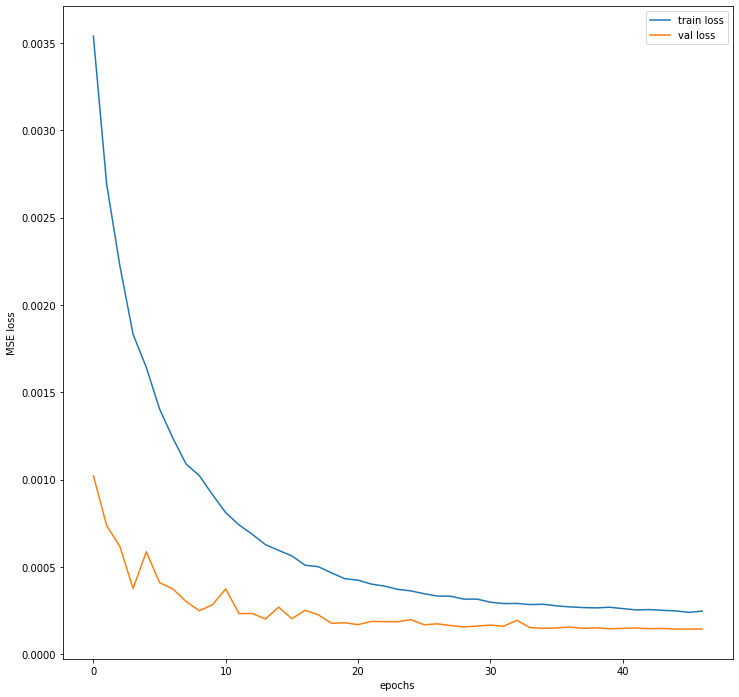

In [98]:
plt.figure() 
plt.figure(figsize=(12,12))
plt.xlabel("epochs")
plt.ylabel("MSE loss") 
plt.plot(train_losses[3:], label="train loss") 
plt.plot(val_losses[3:], label="val loss") 
plt.legend() 
plt.savefig("TFT train loss")
plt.show() 

In [99]:
# inference 

# load test model 
test_model = TFN(n_var_past_cont = features,
                 n_var_future_cont = 0, 
                 n_var_past_disc = [13, 32, 25], 
                 n_var_future_disc = [13, 32, 25],
                 dim_model = 160)  

checkpoint = torch.load("TFT_EMNLP_example.pt") 

test_model.load_state_dict(checkpoint)

test_model.eval() 

test_model.cuda() 

TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=5440, out_features=34, bias=True)
      (fc1): Linear(in_features=5440, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=34, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=34, out_features=34, bias=True)
        (fc2): Linear(in_features=34, out_features=34, bias=True)
      )
      (norm): LayerNorm((34,), eps=1e-05, elementwise_aff

In [100]:
test_dataset = CustomDataset(test_cont, test_disc, test_targets, test_future_discs) 
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)


In [101]:
predicted, actual = [],[] 
for batch in tqdm(test_dataloader, desc="Testing"):
    past_cont = batch['past_cont'].to(device) 
    past_disc = batch['past_disc'].to(device) 
    target_seq = batch['target_seq'].to(device) 
    future_disc = batch['future_disc'].to(device) 
    
    past_disc = one_hot(past_disc, [13,32,25]) 
    future_disc = one_hot(future_disc, [13,32,25]) 
    test_model.reset(batch_size=past_cont.shape[0], gpu=True)
    with torch.no_grad():
        net_out, vs_weights = test_model(past_cont, past_disc, None, future_disc)
    
    pred = net_out.detach().cpu().numpy().flatten()
    for p in pred:
        predicted.append(p)
    
    act = target_seq.detach().cpu().numpy().flatten() 
    for a in act:
        actual.append(a)

Testing:   0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from 

In [102]:
print("MSE = {}".format(mean_squared_error(actual, predicted))) 
print("MAE = {}".format(mean_absolute_error(actual, predicted)))  

MSE = 0.12043377757072449
MAE = 0.296918660402298


<Figure size 432x288 with 0 Axes>

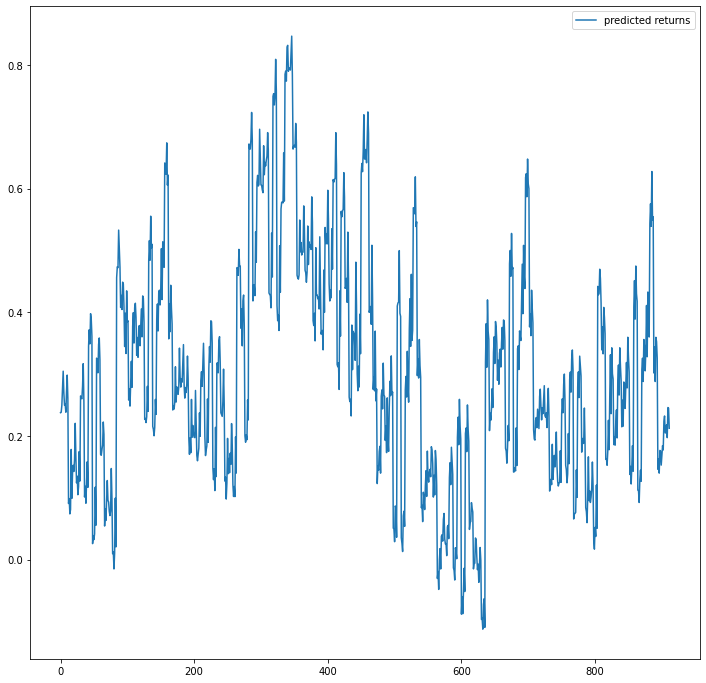

In [103]:
plt.figure() 
plt.figure(figsize=(12,12)) 
plt.plot(predicted, label="predicted returns")
plt.legend()

<Figure size 432x288 with 0 Axes>

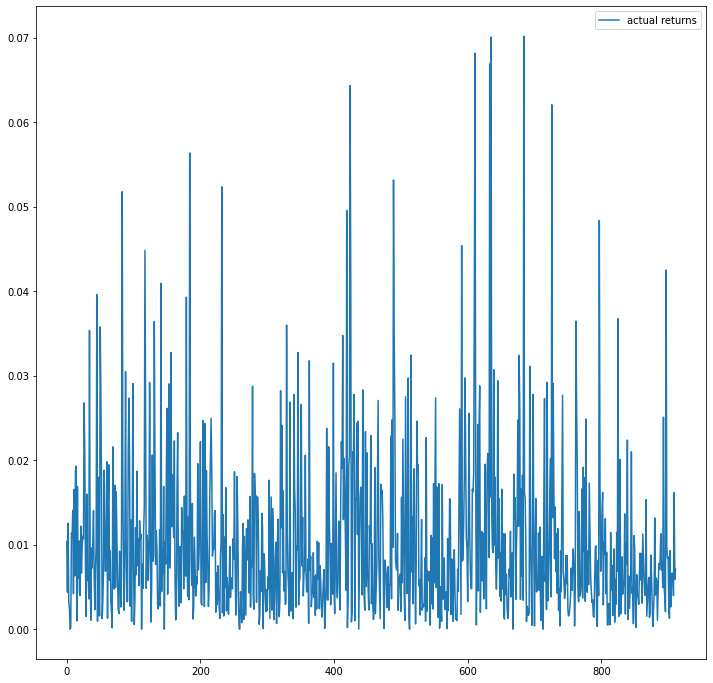

In [104]:
plt.figure() 
plt.figure(figsize=(12,12)) 
plt.plot(actual, label="actual returns")
plt.legend()